Develop,train,test and cross-validate three alternative models

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn. preprocessing import MinMaxScaler
from keras. layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn. preprocessing import MinMaxScaler
from sklearn import linear_model
from keras. models import Sequential
from keras. layers import Dense
import keras. backend as K
from keras. callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras. models import load_model
from keras. layers import LSTM
from keras. utils.vis_utils import plot_model

In [ ]:
from pandas import read_csv
from matplotlib import pyplot
series = read_csv('convictions_returns.csv')#, parse_dates=['date']), index_col='date')

series['RoR_date'] = (series.groupby('symbol')['adj_close_date'].apply(pd.Series.pct_change) + 1)
series['RoR_mtd'] = (series.groupby('symbol')['adj_close_mtd'].apply(pd.Series.pct_change) + 1)
series['RoR_qtd'] = (series.groupby('symbol')['adj_close_qtd'].apply(pd.Series.pct_change) + 1)
series['RoR_htd'] = (series.groupby('symbol')['adj_close_htd'].apply(pd.Series.pct_change) + 1)
series['RoR_ytd'] = (series.groupby('symbol')['adj_close_ytd'].apply(pd.Series.pct_change) + 1)

In [ ]:
#series_plot = series.groupby('symbol')
#series_plot['adj_close_ytd'].plot()
#series.tail(50)

df = series.dropna()
#df

Podział zbioru danych na wektor ze zmiennymi objaśnianymi i wektor ze zmiennymi objaśniającymi. Najpierw wyszczególniamy kolumny , które weźmiemy opd uwagę w dalszym badaniu.

In [ ]:
# Dividing data into Y and X
# Set Target Variable
#Y_col = ['adj_close_date','adj_close_mtd','adj_close_qtd','adj_close_htd','adj_close_ytd']
Y_col = ['RoR_date','RoR_mtd','RoR_qtd','RoR_htd','RoR_ytd']
Others = ['Unnamed: 0','symbol','sector','date']
all_column = series.columns
X_col = np.setdiff1d(all_column, Y_col)
X_col = np.setdiff1d(X_col, Others)


Następnie dzielimy zbiór danych na potrzebne części.
https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [ ]:
Y_name = Y_col[2] #Y jest wybieralne 

#df=series
Y = pd.DataFrame(df[Y_name]) 
X = pd.DataFrame(df[X_col])

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
Y = scaler.fit_transform(Y)
X = scaler.fit_transform(X)


In [ ]:
#Splitting to Training set and Test set
# timesplit= TimeSeriesSplit(n_splits=10)
# for train_index, test_index in timesplit.split(X):
#        X_train, X_test = X[:len(train_index)], X[len(train_index): (len(train_index)+len(test_index))]
#        y_train, y_test = Y[:len(train_index)].values.ravel(), Y[len(train_index): (len(train_index)+len(test_index))].values.ravel()

Poniżej realizujemy podział zbiorów na uczące i testowe.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 23, shuffle = True)

Realizacja regresji liniowej nr 1.

Score:  -2.3355480527316378e+21
Weights:  [[ 3.63487723e+10 -1.05650682e+10  3.87748772e+09 -6.29789081e+09
  -2.53531492e+10 -4.34058678e-01  1.41104169e-02 -3.21557542e+00
  -2.76787734e-03  1.37810933e-02 -4.00701245e-03  9.35075668e-01
   6.64103704e-03 -1.08383073e+00  4.37946414e+00 -2.38084363e-01
   1.13906288e+00 -2.67001987e-03 -1.49029076e+00  7.22670555e-03
   6.82234764e-04  1.59165859e-01 -1.17194057e-02  0.00000000e+00
   1.98364258e-03]]
RMSE :  2001491805.849590


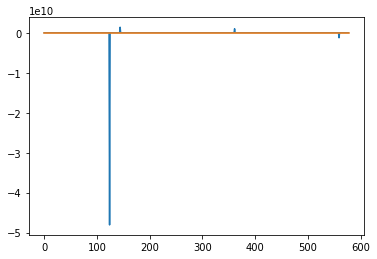

In [34]:
from sklearn.linear_model import LinearRegression

lineReg = LinearRegression()
lineReg.fit(X_train, y_train)
print('Score: ', lineReg.score(X_test, y_test))
print('Weights: ', lineReg.coef_)

Y_pred_test = lineReg.predict(X_test)
rmse = np.sqrt(MSE(y_test, Y_pred_test))
print("RMSE : % f" %(rmse))

plt.plot(lineReg.predict(X_test))
plt.plot(y_test)
plt.show()

Realizacja regresji liniowej nr 2.

In [ ]:
#@title
# Import the required libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

# Dividing data into Y and X
# Set Target Variable
Y_col = ['adj_close_date','adj_close_mtd','adj_close_qtd','adj_close_htd','adj_close_ytd']
Others = ['Unnamed: 0','symbol','sector','date']
all_column = series.columns
X_col = numpy.setdiff1d(all_column, Y_col)
X_col = numpy.setdiff1d(X_col, Others)

data = df
# Consider features we want to work on:
X = data[X_col]
Y = data['adj_close_date']
# Generating training and testing data from our data:
# We are using 80% data for training.
train = data[:(int((len(data)*0.8)))]
test = data[(int((len(data)*0.8))):]
#Modeling:
#Using sklearn package to model data :
regr = linear_model.LinearRegression()
train_x = np.array(train[X_col])
train_y = np.array(train[Y_col])


regr.fit(train_x,train_y)
test_x = np.array(test[X_col])
test_y = np.array(test[Y_col])
# print the coefficient values:
#coeff_data = pd.DataFrame(regr.coef_ , X.columns , columns=['Coefficients'])
#coeff_data
#Now let’s do prediction of data:
Y_pred = regr.predict(test_x)
# Check accuracy:
from sklearn.metrics import r2_score
R = r2_score(test_y , Y_pred)
print ('R²:',R)


R²: -1.831762022218026e+43


Realizacja regresji liniowej nr 3.

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

model = linear_model.LinearRegression()
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)

model.fit(X_train, y_train)

Y_pred_train = model.predict(X_train)
#print('Coefficients:', model.coef_)
#print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(y_train, Y_pred_train))
rmse = np.sqrt(MSE(y_train, Y_pred_train))
print("RMSE : % f" %(rmse))
#print('Coefficient of determination (R^2): %.2f'
#      % r2_score(y_train, Y_pred_train))

X_test = pd.DataFrame(X_test)
Y_pred_test = model.predict(X_test)
#print('Coefficients:', model.coef_)
#print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(y_test, Y_pred_test))
rmse = np.sqrt(MSE(y_test, Y_pred_test))
print("RMSE : % f" %(rmse))
#print('Coefficient of determination (R^2): %.2f'
#      % r2_score(y_test, Y_pred_test))

Coefficients: [[-2.33412658e+20  4.69463587e+20  8.00271653e+19 -2.86242187e+23
   1.89697867e+18 -2.14520303e+21  1.87324963e+20 -1.32807751e+22
   1.73063937e+20 -2.92980351e+20 -1.50646915e+19  1.48734425e+19
   9.26826702e+21  8.83565057e+19 -1.47322968e+23  1.94458002e+22
   1.21189611e+22 -3.68342768e+14  0.00000000e+00 -6.15174615e+21]]
Intercept: [3.41705256e+23]
Mean squared error (MSE): 131181326637659779318769931675649179699317342994432.00
Coefficient of determination (R^2): 0.00
Coefficients: [[-2.33412658e+20  4.69463587e+20  8.00271653e+19 -2.86242187e+23
   1.89697867e+18 -2.14520303e+21  1.87324963e+20 -1.32807751e+22
   1.73063937e+20 -2.92980351e+20 -1.50646915e+19  1.48734425e+19
   9.26826702e+21  8.83565057e+19 -1.47322968e+23  1.94458002e+22
   1.21189611e+22 -3.68342768e+14  0.00000000e+00 -6.15174615e+21]]
Intercept: [3.41705256e+23]
Mean squared error (MSE): 117077212287958047483245705424865746479745073152.00
Coefficient of determination (R^2): -9.94


Realizacja XGBoosting.

In [32]:
# Necessary imports
import numpy as np
import pandas as pd
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
  
# Train and test set are converted to DMatrix objects,
# as it is required by learning API.
train_dmatrix = xg.DMatrix(data = X_train, label = y_train)
test_dmatrix = xg.DMatrix(data = X_test, label = y_test)
  
# Parameter dictionary specifying base learner
param = {"booster":"gblinear", "objective":"reg:linear"}
  
xgb_r = xg.train(params = param, dtrain = train_dmatrix, num_boost_round = 10)
pred = xgb_r.predict(test_dmatrix)
  
# RMSE Computation
rmse = np.sqrt(MSE(y_test, pred))
print("RMSE : % f" %(rmse))
#print('Coefficient of determination (R^2): %.2f'
#      % r2_score(y_test, pred))

[21:50:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE :  0.041674


In [33]:
#cross validate
data_dmatrix = xg.DMatrix(data=X_train, label=y_train)
xgb_cv = xg.cv(dtrain=data_dmatrix, params=param, nfold=5, metrics = 'rmse',seed=42) 
print(xgb_cv)

[21:50:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:50:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:50:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:50:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:50:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0         0.022045        0.001425        0.022180       0.004375
1         0.020323        0.000904        0.020274       0.003111
2         0.019907        0.000879        0.019850       0.003064
3         0.019572        0.000859        0.019508       0.003086
4         0.019272        0.000848 

Realizacja LSTM.

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=10,batch_size=32)

Epoch 1/10
556/556 [==============================] - 38s 56ms/step - loss: 0.0185
Epoch 2/10
556/556 [==============================] - 32s 58ms/step - loss: 0.0050
Epoch 3/10
556/556 [==============================] - 32s 58ms/step - loss: 0.0043
Epoch 4/10
556/556 [==============================] - 32s 57ms/step - loss: 0.0038
Epoch 5/10
556/556 [==============================] - 32s 57ms/step - loss: 0.0032
Epoch 6/10
556/556 [==============================] - 32s 57ms/step - loss: 0.0026
Epoch 7/10
556/556 [==============================] - 33s 59ms/step - loss: 0.0020
Epoch 8/10
556/556 [==============================] - 32s 57ms/step - loss: 0.0015
Epoch 9/10
556/556 [==============================] - 32s 57ms/step - loss: 0.0010
Epoch 10/10
501/556 [==========================>...] - ETA: 3s - loss: 6.9498e-04

In [30]:
import lightgbm as lgb
lgbm = lgb.LGBMRegressor()

lgbm.fit(X_train, y_train)
Y_pred_lgbm = lgbm.predict(X_test)

In [31]:
from sklearn.model_selection import cross_validate
lgbm_scores = cross_validate(lgbm, X_train, y_train, scoring='neg_mean_squared_error')

print(lgbm_scores)
for k, v in lgbm_scores.items():
    print(k, v.mean())

{'fit_time': array([0.28782678, 0.26724815, 0.27755523, 0.26869154, 0.28563976]), 'score_time': array([0.00635934, 0.00664377, 0.00597954, 0.00631475, 0.0068984 ]), 'test_score': array([-0.00013801, -0.00042009, -0.00015606, -0.00027319, -0.00016887])}
fit_time 0.2773922920227051
score_time 0.0064391613006591795
test_score -0.00023124405583520367
